In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/sn/ERAv1/main_repo')

In [3]:
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_lr_finder import LRFinder

from models.resnet import ResNet18
from main import train_loader, test_loader, train, test, train_losses, test_losses, train_acc, test_acc, lrs, criterion
from utils import get_incorrect_preds, plot_incorrect_preds, plot_sample_imgs, plot_gcam_incorrect_preds

/home/sn/anaconda3/envs/fastai2022/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 10])
Files already downloaded and verified
(1600000, 32, 3)
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]
Files already downloaded and verified
Files already downloaded and verified
cuda available? True


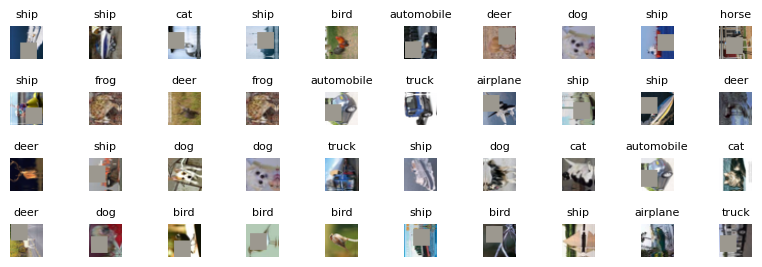

In [4]:
plot_sample_imgs(train_loader)

In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

 91%|██████████████████████████████████████▏   | 91/100 [00:23<00:02,  3.80it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.28E-04


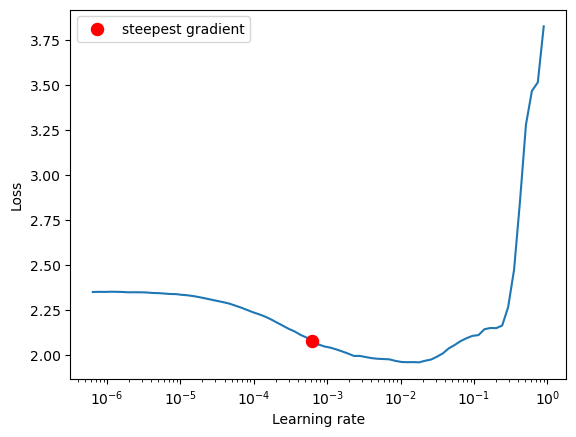

In [6]:
model =  ResNet18().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [8]:
EPOCHS = 20
max_lr = 6.28E-04
model =  ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=1e-2)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=max_lr, 
                                          pct_start=0.2, 
                                          epochs=EPOCHS, 
                                          div_factor=100.0, 
                                          final_div_factor=100.0, 
                                          steps_per_epoch=len(train_loader))

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, scheduler, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=1.526293396949768 Batch_id=97 Accuracy=30.56: 100%|█| 98/98 [00:25<00:00,  



Test set: Average loss: 0.0030, Accuracy: 4528/10000 (45.28%)

EPOCH: 2


Loss=1.1871672868728638 Batch_id=97 Accuracy=50.34: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0028, Accuracy: 5221/10000 (52.21%)

EPOCH: 3


Loss=1.066929817199707 Batch_id=97 Accuracy=59.10: 100%|█| 98/98 [00:25<00:00,  



Test set: Average loss: 0.0023, Accuracy: 5903/10000 (59.03%)

EPOCH: 4


Loss=0.8543505668640137 Batch_id=97 Accuracy=64.99: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0028, Accuracy: 5291/10000 (52.91%)

EPOCH: 5


Loss=0.8354001045227051 Batch_id=97 Accuracy=68.91: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0032, Accuracy: 5373/10000 (53.73%)

EPOCH: 6


Loss=0.8704348206520081 Batch_id=97 Accuracy=70.58: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0017, Accuracy: 7023/10000 (70.23%)

EPOCH: 7


Loss=0.7021999955177307 Batch_id=97 Accuracy=72.98: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0024, Accuracy: 6069/10000 (60.69%)

EPOCH: 8


Loss=0.742189347743988 Batch_id=97 Accuracy=73.99: 100%|█| 98/98 [00:25<00:00,  



Test set: Average loss: 0.0020, Accuracy: 6724/10000 (67.24%)

EPOCH: 9


Loss=0.7982876300811768 Batch_id=97 Accuracy=75.80: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0016, Accuracy: 7160/10000 (71.60%)

EPOCH: 10


Loss=0.66279137134552 Batch_id=97 Accuracy=76.78: 100%|█| 98/98 [00:25<00:00,  3



Test set: Average loss: 0.0019, Accuracy: 6903/10000 (69.03%)

EPOCH: 11


Loss=0.6366965174674988 Batch_id=97 Accuracy=78.96: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0014, Accuracy: 7659/10000 (76.59%)

EPOCH: 12


Loss=0.5560165047645569 Batch_id=97 Accuracy=80.02: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0014, Accuracy: 7598/10000 (75.98%)

EPOCH: 13


Loss=0.5523659586906433 Batch_id=97 Accuracy=81.25: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0016, Accuracy: 7381/10000 (73.81%)

EPOCH: 14


Loss=0.45063459873199463 Batch_id=97 Accuracy=83.12: 100%|█| 98/98 [00:25<00:00,



Test set: Average loss: 0.0010, Accuracy: 8336/10000 (83.36%)

EPOCH: 15


Loss=0.498821496963501 Batch_id=97 Accuracy=84.74: 100%|█| 98/98 [00:25<00:00,  



Test set: Average loss: 0.0015, Accuracy: 7800/10000 (78.00%)

EPOCH: 16


Loss=0.3527129590511322 Batch_id=97 Accuracy=86.82: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0007, Accuracy: 8750/10000 (87.50%)

EPOCH: 17


Loss=0.3255746066570282 Batch_id=97 Accuracy=88.90: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0007, Accuracy: 8919/10000 (89.19%)

EPOCH: 18


Loss=0.3105427324771881 Batch_id=97 Accuracy=90.30: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0006, Accuracy: 8973/10000 (89.73%)

EPOCH: 19


Loss=0.2643827497959137 Batch_id=97 Accuracy=91.55: 100%|█| 98/98 [00:25<00:00, 



Test set: Average loss: 0.0006, Accuracy: 9061/10000 (90.61%)

EPOCH: 20


Loss=0.24433524906635284 Batch_id=97 Accuracy=92.48: 100%|█| 98/98 [00:25<00:00,



Test set: Average loss: 0.0006, Accuracy: 9098/10000 (90.98%)



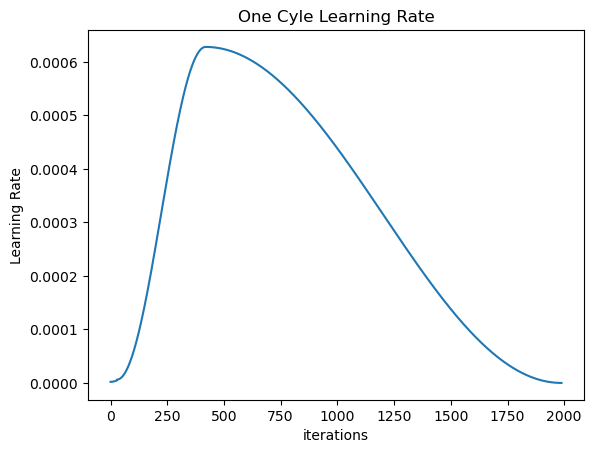

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(lrs)
plt.xlabel('iterations') 
plt.ylabel('Learning Rate') 
  
# displaying the title
plt.title("One Cyle Learning Rate")
plt.show()

Text(0.5, 1.0, 'Test Accuracy')

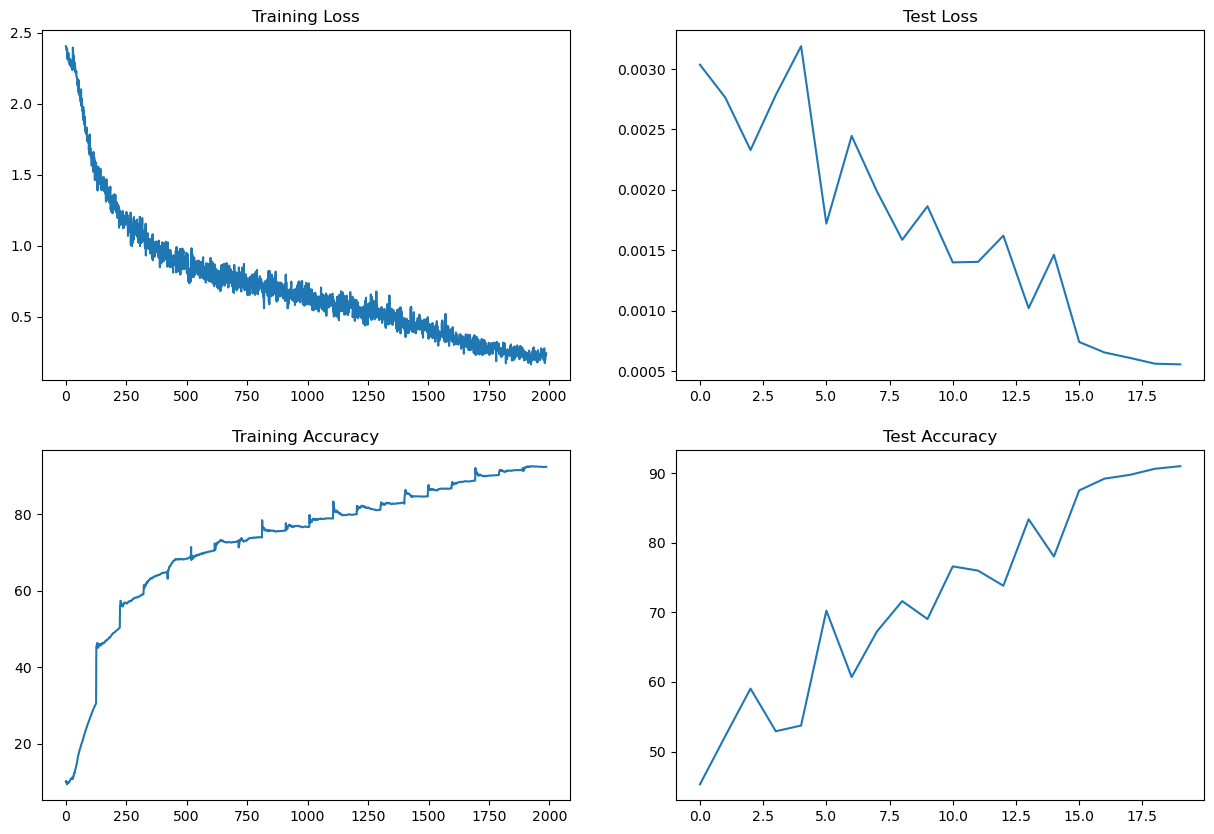

In [10]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Classes in order Actual and Predicted


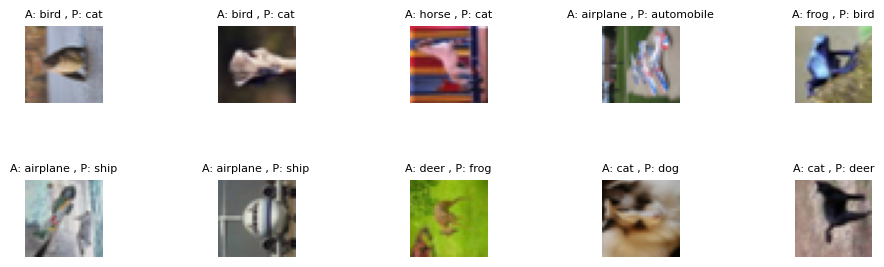

In [11]:
true_wrong, incorrect_examples, pred_wrong = get_incorrect_preds(model, test_loader)
plot_incorrect_preds(true_wrong, incorrect_examples, pred_wrong)

Classes in order Actual and Predicted


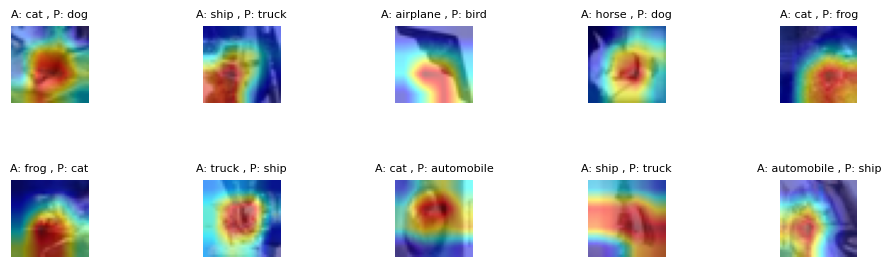

In [12]:
plot_gcam_incorrect_preds(model, true_wrong, incorrect_examples, pred_wrong)